# Face detection on masked images


In [1]:
import os, sys
sub_module_dir = os.path.abspath(os.path.join('../retinaface-tf2'))
if sub_module_dir not in sys.path: # add retinaface-tf2 repo to PATH
    sys.path.append(sub_module_dir)
    
from pathlib import Path
from modules.models import RetinaFaceModel
from modules.utils import pad_input_image, recover_pad_output, load_yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import random
import os

### Setup 

In [2]:
ROOT_DIR = os.path.dirname(os.path.abspath(os.curdir))
DATA_DIR = Path(ROOT_DIR) / 'data'
RAW_IMAGES_DIR = DATA_DIR / 'raw_images'

REAL_VALID_DIR = DATA_DIR / 'validation' / 'real'
REAL_VALID_DIR.mkdir(exist_ok=True)

REAL_TEST_DIR = DATA_DIR / 'test'
REAL_TEST_DIR.mkdir(exist_ok=True)

DETECTOR_RESULT_DIR = DATA_DIR / 'detector_results'
DETECTOR_RESULT_DIR.mkdir(exist_ok=True)

DETECTOR_BBOX_ANNOTATIONS = DATA_DIR / 'detector_annotations.csv'

GROUND_TRUTH_ANNOTATIONS = DATA_DIR / 'image_annotations.csv'

# Add retinaface-tf2 submodule to PATH
RETINAFACE_DIR = os.path.join(ROOT_DIR, 'retinaface-tf2')
if RETINAFACE_DIR not in sys.path: # add retinaface-tf2 repo to PATH
    sys.path.append(RETINAFACE_DIR)
RETINAFACE_CFG_PATH = Path(RETINAFACE_DIR) / 'configs' / 'retinaface_mbv2.yaml'

### Detect faces

In [3]:
retinaface_cfg = load_yaml(RETINAFACE_CFG_PATH)

# define network
model = RetinaFaceModel(retinaface_cfg, training=False, iou_th=0.4, score_th=0.5)

# load checkpoint
tf.get_logger().setLevel('ERROR')
checkpoint_dir = os.path.join('../retinaface-tf2', retinaface_cfg['sub_name'])
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

/home/toon/mask_env_37/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [4]:
real_raw_img = list(sorted(RAW_IMAGES_DIR.glob('*.jpg')))

random.seed(2362)
random.shuffle(real_raw_img)

VALID_PCT_REAL_IMAGES = 0.5     

Detector extracted a face with 0 rows or columns, skipping this one for /home/toon/faces_new/face-mask-detection/data/raw_images/131.jpg
Detector extracted a face with 0 rows or columns, skipping this one for /home/toon/faces_new/face-mask-detection/data/raw_images/46.jpg
Detector extracted a face with 0 rows or columns, skipping this one for /home/toon/faces_new/face-mask-detection/data/raw_images/192.jpg
Detector extracted a face with 0 rows or columns, skipping this one for /home/toon/faces_new/face-mask-detection/data/raw_images/101.jpg
Detector extracted a face with 0 rows or columns, skipping this one for /home/toon/faces_new/face-mask-detection/data/raw_images/245.jpg
Detector extracted a face with 0 rows or columns, skipping this one for /home/toon/faces_new/face-mask-detection/data/raw_images/130.jpg
Detector extracted a face with 0 rows or columns, skipping this one for /home/toon/faces_new/face-mask-detection/data/raw_images/149.jpg
Detector extracted a face with 0 rows or c

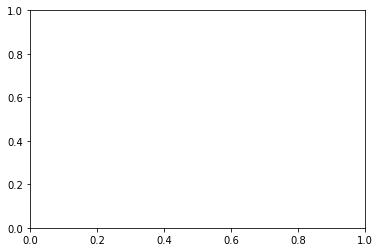

In [5]:
detector_bbox = pd.DataFrame(columns=['img','x','y','w','h'])

for idx, fn in enumerate(real_raw_img):
    
    destination_dir = REAL_VALID_DIR if idx <= int(VALID_PCT_REAL_IMAGES*len(real_raw_img)) else REAL_TEST_DIR
    
    if fn.name == '157.jpg':
        # this one crashes the kernel, don't know why..
        continue
        
    img_raw = cv2.imread(str(fn))
    img_height, img_width, _ = img_raw.shape
    img = np.float32(img_raw.copy())
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, pad_params = pad_input_image(img, max_steps=max(retinaface_cfg['steps']))
    
    outputs = model(img[np.newaxis, ...]).numpy()
    outputs = recover_pad_output(outputs, pad_params)
      
    for prior_index in range(len(outputs)):
        ann = outputs[prior_index]
        x1, y1, x2, y2 = int(ann[0] * img_width), int(ann[1] * img_height), \
                         int(ann[2] * img_width), int(ann[3] * img_height)
        
        detector_bbox.loc[len(detector_bbox)] = [fn.name,x1,y1,x2-x1,y2-y1]

        
        rect = plt.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=3,edgecolor='green',facecolor='none')
        plt.gca().add_patch(rect)
        
        cropped_face = img[y1:y2, x1:x2]
        
        if cropped_face.shape[0] == 0 or cropped_face.shape[1] == 0:
            print(f"Detector extracted a face with 0 rows or columns, skipping this one for {fn}")
            continue
            
        output_fn = destination_dir / (fn.stem + '_' + str(prior_index) + '.jpg')
        cv2.imwrite(str(output_fn), cv2.cvtColor(cropped_face, cv2.COLOR_RGB2BGR))     
    
detector_bbox.to_csv(DETECTOR_BBOX_ANNOTATIONS, index=False)

## Evaluate wrt ground truth

In [6]:
def bb_intersection_over_union(boxA, boxB):
    '''
    from https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    '''
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [7]:
ground_truth = pd.read_csv(GROUND_TRUTH_ANNOTATIONS)

tp = 0
fp = 0
fn = 0

correct = []
mistakes = []
    
for idx, img_fn in enumerate(real_raw_img):
    img = cv2.imread(str(img_fn))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure()
    plt.imshow(img/255)
    
    ground_truth_fn = ground_truth[ground_truth.img == img_fn.name]
    
    gt_boxes = []
    for row_idx in range(ground_truth_fn.shape[0]):
        ground_truth_annotation = ground_truth_fn.iloc[row_idx]

        x = ground_truth_annotation.x.item()
        y = ground_truth_annotation.y.item()
        w = ground_truth_annotation.w.item()
        h = ground_truth_annotation.h.item()
        
        gt_boxes.append((x,y,x+w,y+h))
        
        rect = plt.Rectangle((x,y),w,h,linewidth=3,edgecolor='green',facecolor='none')
        plt.gca().add_patch(rect)
        
    bbox_fn = detector_bbox[detector_bbox.img == img_fn.name]
   
    pred_boxes = []
    for row_idx in range(bbox_fn.shape[0]):
        pred_annotation = bbox_fn.iloc[row_idx]

        x = pred_annotation.x
        y = pred_annotation.y
        w = pred_annotation.w
        h = pred_annotation.h
        
        pred_boxes.append((x,y,x+w,y+h))
        
        rect = plt.Rectangle((x,y),w,h,linewidth=3,edgecolor='red',facecolor='none')
        plt.gca().add_patch(rect)
    
    plt.axis('off')
    plt.savefig(DETECTOR_RESULT_DIR / img_fn.name, bbox_inches='tight', pad_inches=0)
    plt.close()
    
    fn_prev = fn
    fp_prev = fp
    
    # first we check for each ground truth bounding box whether it was detected
    for gt_box in gt_boxes:
        times_found = 0
        for pred_box in pred_boxes: 
            iou = bb_intersection_over_union(gt_box, pred_box)
            if iou >= 0.5:
                times_found += 1
        
        if times_found > 0:
            # the face was detected at least once, so it is a true positive
            tp += 1
        
            # if it is detected more than once, we add the duplicate detections to the false positives
            n_duplicates = times_found - 1
            if n_duplicates > 0:
                fp += n_duplicates
        
        if times_found == 0:
            fn += 1
        
    # we also have to check for detected bounding boxes that do not overlap with any ground truth bounding box,
    # as these are counted as false negatives
    for pred_box in pred_boxes:
        found = False
        for gt_box in gt_boxes:
            iou = bb_intersection_over_union(gt_box, pred_box)
            if iou > 0.5:
                found = True
                break
        if not found:
            fp += 1
            
    if fn_prev != fn or fp_prev != fp:
        mistakes.append(DETECTOR_RESULT_DIR / img_fn.name)
    else:
        correct.append(DETECTOR_RESULT_DIR / img_fn.name)

IndentationError: expected an indented block (<ipython-input-7-1b3edf9b78a8>, line 71)

In [ ]:
print(f"Number of true positives: {tp}")
print(f"Number of false positives: {fp}")
print(f"Number of false negatives: {fn}")

In [ ]:
n_to_plot = 16
to_plot = random.sample(correct,n_to_plot)

nrow = np.ceil(np.sqrt(n_to_plot))
ncol = nrow

plt.figure(figsize=(15,15))
for idx, x in enumerate(to_plot):
    plt.subplot(nrow, ncol, idx+1)
    img = cv2.imread(str(x))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Sample of images with all faces detected correctly', size=20, y=0.92)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [ ]:
n_to_plot = 16
to_plot = random.sample(mistakes,n_to_plot)

nrow = np.ceil(np.sqrt(n_to_plot))
ncol = nrow

plt.figure(figsize=(15,15))
for idx, x in enumerate(to_plot):
    plt.subplot(nrow, ncol, idx+1)
    img = cv2.imread(str(x))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle('Sample of images with mistakes in face detection', size=20, y=0.92)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()